In [1]:
import importlib

import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from matplotlib import pyplot as plt
import seaborn as sns
import logomaker as lm

import tensorflow as tf

from Modules import utils, tf_utils
from Modules.tf_utils import mae_cor, correlate, get_profile
import kMC_sequence_design
from kMC_sequence_design import get_profile_hint, rmse, GC_energy, get_profile_chunk

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
sns.set_theme()

2023-11-06 17:12:37.740081: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [42]:
importlib.reload(utils)
importlib.reload(tf_utils)
importlib.reload(kMC_sequence_design)

<module 'kMC_sequence_design' from '/home/alex/mnhn-internship_DeepCNN_ChIP-seq/kMC_sequence_design.py'>

Models

In [2]:
model_pol_name = 'model_myco_pol_17'
# with tf.distribute.MirroredStrategy().scope():
model_pol = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_pol_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_nuc_name = 'model_myco_nuc_2'
model_nuc = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_nuc_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_coh_name = 'model_myco_coh_14'
model_coh = tf.keras.models.load_model(f'/home/alex/shared_folder/SCerevisiae/Trainedmodels/{model_coh_name}/model',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_rna_name = 'weight_CNN_RNA_seq_2001_12_8_4_SRR7131299' # order 'ATGC'
model_rna = tf.keras.models.load_model(f'/home/alex/shared_folder/JB_seqdes/{model_rna_name}.hdf5',
                                       custom_objects={'correlate': correlate, 'mae_cor': mae_cor})
model_rna.input_shape

2023-11-06 11:00:33.049603: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-11-06 11:00:33.162697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 11:00:33.168118: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-11-06 11:00:33.168175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 11:00:33.168904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID

(None, 2001, 4, 1)

In [12]:
with np.load('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.npz') as f:
    one_hot_yeast = {k: f[k] for k in f.keys() if k[:3] == 'chr'}
print(list(one_hot_yeast.keys()))

['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX', 'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI']


# kinetic Monte-Carlo

Flanking regions file

In [ ]:
# flanks = {'left': [], 'right': [], 'pos': []}
# for k, v in one_hot_yeast.items():
#     pos = np.random.randint(1000, len(v)-1000)
#     window = v[pos - 1000:pos+1000]
#     assert len(window) == 2000
#     assert window.sum() == 2000
#     window = np.argmax(window, axis=-1)
#     flanks['left'].append(window[:1000])
#     flanks['right'].append(window[1000:])
#     flanks['pos'].append(pos)
# for k, v in flanks.items():
#     flanks[k] = np.array(v)
# np.savez('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco_random1kbflanks_ACGTidx.npz', **flanks)

Analysing experiments

In [13]:
def energy_parser(file):
    energies = np.loadtxt(file)
    with open(file, 'r') as f:
        n_seqs = 0
        for line in f:
            if n_seqs != 0 and line.startswith('#'):
                break
            if not line.startswith('#'):
                n_seqs += 1
    return np.transpose(energies.reshape(-1, n_seqs, energies.shape[1]), [1, 0, 2])

Energy

(2, 500, 5)
(10, 500, 5)
(10, 500, 5)
(2, 500, 5)


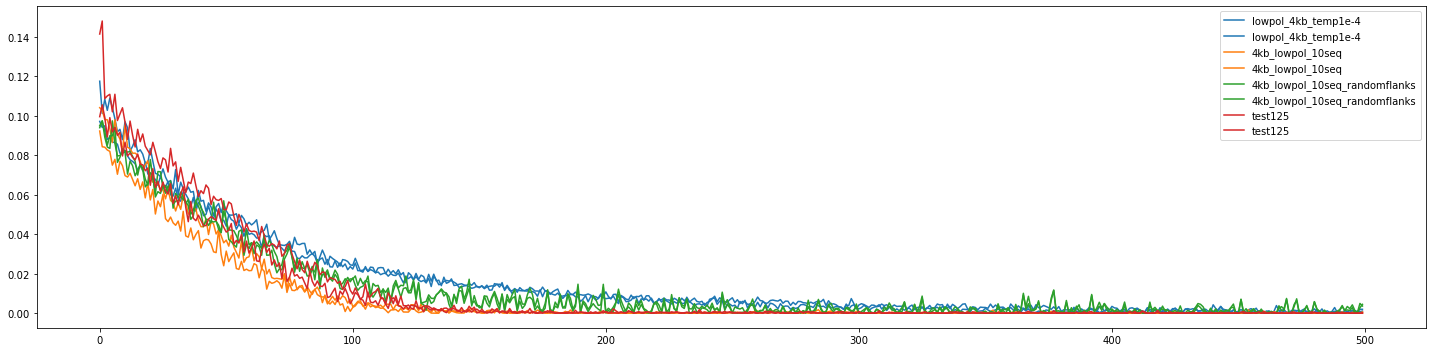

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')#, sharey=True)
temps = ['2e-4', '1e-4', '5e-5']
exp_ids = ['lowpol_4kb_temp1e-4', '4kb_lowpol_10seq', '4kb_lowpol_10seq_randomflanks', 'test125'] # [f'test{n}' for n in range(125, 126)] # ['4kb_lowpol_10seq', '4kb_lowpol_10seq_randomflanks', '4kb_highpol_10seq', '4kb_highpol_10seq_randomflanks', '4kb_peakpol200bp_10seq', '4kb_peakpol200bp_10seq_randomflanks'] # [f'lowpol_4kb_temp{t}' for t in temps] + [f'highpol_4kb_temp{t}_mid' for t in temps] #
# exp_ids = exp_ids[::-1]
exp_labels = exp_ids # ['stride128', 'stride64', 'stride32', 'stride16'] #
for exp_id, exp_lab, color in zip(exp_ids, exp_labels, colors):
    # if int(exp_id[4:]) in [94, 95]:
    #     continue
    # with open(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/config.txt') as f:
    #     print(''.join(f.readlines()))
    energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/energy.txt')
    print(energies.shape)
    ax.plot(energies[:2, :, 0].T, label=exp_lab, color=color)
ax.legend()
# ax.set_xlim(470, 500)
# ax.set_ylim((-0.001, 2))

(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)
(10, 500, 5)


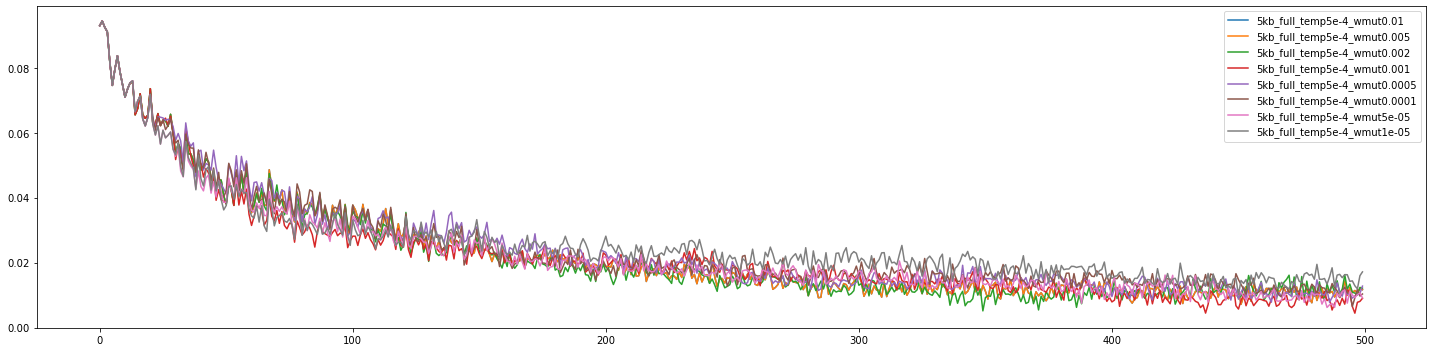

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')#, sharey=True)
exp_ids = [f'test{n}' for n in range(49, 57)]
wmuts = [0.01, 0.005, 0.002, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
exp_labels = [f'5kb_full_temp5e-4_wmut{w}' for w in wmuts]
for exp_id, exp_lab, color in zip(exp_ids, exp_labels, colors):
    energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_id}/energy.txt')
    print(energies.shape)
    ax.plot(energies[:1, :, 0].T, label=exp_lab, color=color)
ax.legend()

Probabilities

(10, 12000)


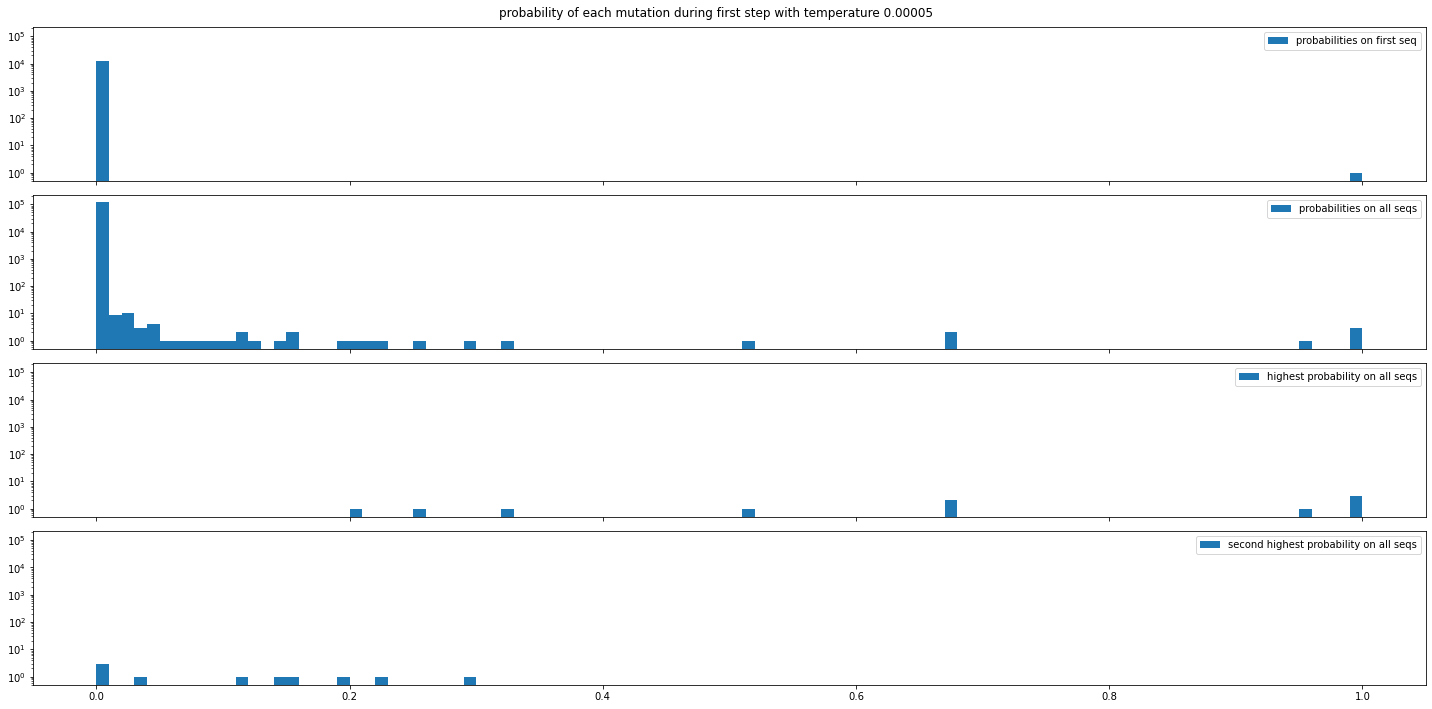

In [38]:
exp_name = '4kb_peakpol200bp_10seq'
step = 0
probs = np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/probs/prob_step{step}.npy')
print(probs.shape)
probs = np.sort(probs, axis=1)
fig, axes = plt.subplots(4, 1, figsize=(20, 10), facecolor='w', layout='tight', sharey=True, sharex=True)
fig.suptitle('probability of each mutation during first step with temperature 0.00005')
axes[0].hist(probs[0], bins=100, range=(0, 1), label='probabilities on first seq')
axes[1].hist(probs.ravel(), bins=100, range=(0, 1), label='probabilities on all seqs')
axes[2].hist(probs[:, -1], bins=100, range=(0, 1), label='highest probability on all seqs')
axes[3].hist(probs[:, -2], bins=100, range=(0, 1), label='second highest probability on all seqs')
for ax in axes:
    ax.set_yscale('log')
    ax.set_ylim(bottom=5e-1)
    ax.legend()
plt.show()

In [39]:
# exp_name = 'lowpol_4kb_temp1e-4'
energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/energy.txt')
probs = []
for step in range(energies.shape[1]):
    probs.append(np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/probs/prob_step{step}.npy'))
probs = np.stack(probs, axis=1)
print(probs.shape)
probs = np.sort(probs, axis=-1)

(10, 500, 12000)


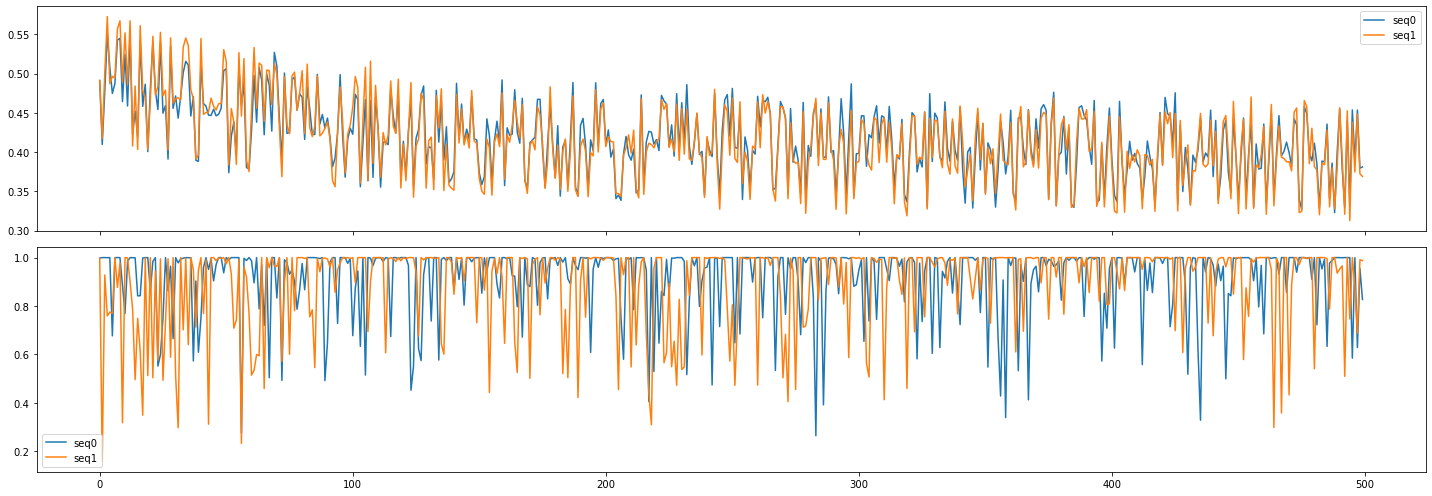

In [40]:
start = 0
stop = 2
fig, axes = plt.subplots(2, 1, figsize=(20, 7), facecolor='w', layout='tight', sharex=True)
axes[0].plot(energies[start:stop, :, 0].T, label=[f'seq{i}' for i in range(start, stop)])
axes[1].plot(probs[start:stop, :, -1].T, label=[f'seq{i}' for i in range(start, stop)])
for ax in axes:
    ax.legend()
plt.show()

Designed sequences

In [130]:
# exp_ids = ['lowpol_4kb_temp1e-4', '4kb_lowpol_10seq', '4kb_lowpol_10seq_randomflanks', 'test125']
exp_name = '4kb_lowpol_10seq_randomflanks' # 'lowpol_4kb_temp1e-4' # '4kb_peakpol200bp_10seq' #
seqs = [np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/start_seqs.npy')]
step = 0
while True:
    try:
        seqs.append(np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/mut_seqs_step{step}.npy'))
        step += 1
    except FileNotFoundError:
        break
seqs = np.stack(seqs, axis=1)
print(seqs.shape)

(10, 501, 4000)


In [6]:
myseq = seqs[0, -1]
myseqstr = ''.join(np.array(list('ACGT'))[myseq])
print(myseq[1500:1750])
print(myseqstr[1500:1750])
print(myseqstr[1500:1600])
print(myseqstr[1575:1675])
print(myseqstr[1650:1750])

[1 3 3 1 0 3 1 3 1 0 1 0 3 2 1 0 2 1 3 0 3 2 1 2 2 3 2 3 2 0 0 0 0 0 3 0 0
 3 1 1 2 2 1 0 3 0 1 0 2 2 1 1 0 2 2 1 2 0 0 3 3 0 0 3 3 3 1 0 0 2 1 2 0 3
 0 3 3 3 3 3 3 0 0 3 3 3 3 3 3 0 1 3 1 2 2 3 3 2 0 1 2 2 3 0 2 3 3 1 2 1 0
 2 0 0 2 1 2 2 1 2 2 0 2 3 1 3 2 3 1 0 2 3 3 3 3 3 3 3 1 3 3 3 1 2 1 1 0 2
 1 1 0 0 1 3 3 2 0 0 0 0 3 3 3 3 3 3 3 3 1 2 1 0 1 2 0 0 0 2 3 2 0 0 0 0 0
 0 0 0 0 3 2 2 0 0 0 2 0 3 0 0 2 2 0 3 0 1 0 0 0 3 3 3 0 3 1 3 3 2 3 3 2 2
 0 3 0 0 3 3 2 0 0 0 1 3 0 3 3 3 0 1 3 0 0 1 1 3 1 0 3 1]
CTTCATCTCACATGCAGCTATGCGGTGTGAAAAATAATCCGGCATACAGGCCAGGCGAATTAATTTCAAGCGATATTTTTTAATTTTTTACTCGGTTGACGGTAGTTCGCAGAAGCGGCGGAGTCTGTCAGTTTTTTTCTTTCGCCAGCCAACTTGAAAATTTTTTTTCGCACGAAAGTGAAAAAAAAATGGAAAGATAAGGATACAAATTTATCTTGTTGGATAATTGAAACTATTTACTAACCTCATC
CTTCATCTCACATGCAGCTATGCGGTGTGAAAAATAATCCGGCATACAGGCCAGGCGAATTAATTTCAAGCGATATTTTTTAATTTTTTACTCGGTTGAC
TTTTTTAATTTTTTACTCGGTTGACGGTAGTTCGCAGAAGCGGCGGAGTCTGTCAGTTTTTTTCTTTCGCCAGCCAACTTGAAAATTTTTTTTCGCACGA
AACTTGAAAATTTTTTTTCGCACGAAAGTGAAAAAAAAA

In [8]:
print(myseqstr[1666:1679])

TTCGCACGAAAGT


In [258]:
import re
seqlet = myseqstr[1500:1750]
cigar = '5M6I6M2I7M6I1M3I2M2I4M1I4M1D3M3I3M3I11M2I6M1I3M15I3M1I3M1I20M2I8M25I15M3I10M1D3M3I2M4I5M3I4M1D7M1I3M11I5M1I8M'
splits = re.split('(M|D|I)', cigar)[:-1]
seqpos = 0
query = ''
ref = ''
left = 0
total = 0
for i in range(0, len(splits), 2):
    length, mode = splits[i:i+2]
    length = int(length)
    if mode == 'M':
        ref += 'X'*length
        query += seqlet[seqpos:seqpos+length]
        seqpos += length
    elif mode == 'D':
        ref += 'X'*length
        query += '-'*length
    elif mode == 'I':
        ref += '-'*length
        query += seqlet[seqpos:seqpos+length]
        seqpos += length
    else:
        left += length
        print(mode, 'skipped')
    total += length
print(ref)
print(query)

XXXXX------XXXXXX--XXXXXXX------X---XX--XXXX-XXXXXXXX---XXX---XXXXXXXXXXX--XXXXXX-XXX---------------XXX-XXX-XXXXXXXXXXXXXXXXXXXX--XXXXXXXX-------------------------XXXXXXXXXXXXXXX---XXXXXXXXXXXXXX---XX----XXXXX---XXXXXXXXXXXX-XXX-----------XXXXX-XXXXXXXX
CTTCATCTCACATGCAGCTATGCGGTGTGAAAAATAATCCGGCATACAG-GCCAGGCGAATTAATTTCAAGCGATATTTTTTAATTTTTTACTCGGTTGACGGTAGTTCGCAGAAGCGGCGGAGTCTGTCAGTTTTTTTCTTTCGCCAGCCAACTTGAAAATTTTTTTTCGCACGAAAGTGAAAAAAAAAT-GGAAAGATAAGGATACAAATTTAT-CTTGTTGGATAATTGAAACTATTTACTAACCTCATC


In [242]:
# utils.write_fasta({'full': myseqstr, "1500-1750": myseqstr[1500:1750]}, '/home/alex/shared_folder/SCerevisiae/results/generated/test101/4kb_tss_like.fa')

In [ ]:
seq_idx = 0
# print(np.where(seqs[seq_idx, 0] != seqs[seq_idx, -1])[0])
fig, ax = plt.subplots(1, 1, figsize=(20, 3), facecolor='w', layout='tight')
ax.bar(np.where(seqs[seq_idx, 0] != seqs[seq_idx, -1])[0], height=1, width=1.3, color='k')
# ax.set_xlim(0, seqs.shape[-1])

In [ ]:
# start_seqs = np.load(f'/home/alex/shared_folder/SCerevisiae/generated/test9/start_seqs.npy')
# np.save('/home/alex/shared_folder/SCerevisiae/generated/test9/start_seqs_first1.npy', start_seqs[:1])

In [13]:
with np.load('/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco_random1kbflanks_ACGTidx.npz') as f:
    flank_left = f['left']
    flank_right = f['right']

Repredicting

In [45]:
with np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/target.npz') as f:
    target = f['forward']
    target_rev = f['reverse']

In [8]:
target = np.zeros(4000)
target_rev = target

In [9]:
preds, indices = get_profile_chunk(seqs, model_pol, 2048, head_interval=128, middle=False, return_index=True)
preds_rev, indices_rev = get_profile_chunk(seqs, model_pol, 2048, head_interval=128, middle=False, return_index=True, reverse=True)
# preds, indices = get_profile_chunk(seqs, model_nuc, 2001, return_index=True)
# preds_rev, indices_rev = get_profile_chunk(seqs, model_nuc, 2001, return_index=True, reverse=True)
# preds = get_profile_mid1(seqs, model_rna, 2001, one_hot_converter=lambda x: np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True)
# preds_rev = get_profile_mid1(seqs, model_rna, 2001, one_hot_converter=lambda x: np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True, reverse=True)
loss = rmse(target[indices], preds)
loss_rev = rmse(target[indices_rev], preds_rev)
gc_energy = GC_energy(seqs, 0.3834)

2023-11-02 09:01:57.958063: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-11-02 09:01:57.976000: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz
2023-11-02 09:01:58.153810: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-11-02 09:01:58.468161: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-11-02 09:01:58.797578: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-02 09:01:58.797620: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2023-11-02 09:01:58.797995: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-02 09:01:58.798032: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

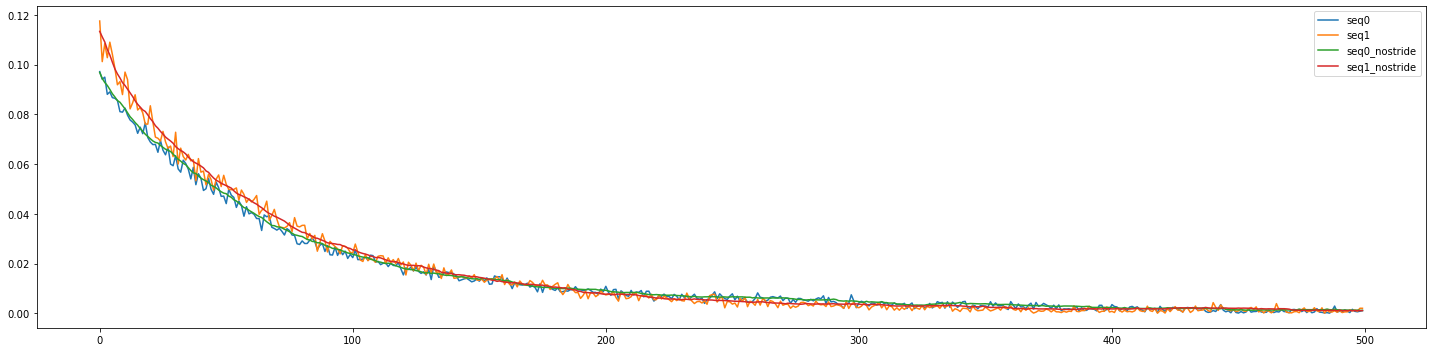

In [10]:
energies = energy_parser(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/energy.txt')
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')
ax.plot(energies[:2, :, 0].T, label=[f'seq{i}' for i in range(2)])
for idx in range(len(seqs)):
    ax.plot(gc_energy[idx, 1:] + loss[idx, 1:] + loss_rev[idx, 1:], label=f'seq{idx}_nostride')
ax.legend()

In [142]:
exp_ids = ['lowpol_4kb_temp1e-4', '4kb_lowpol_10seq', '4kb_lowpol_10seq_randomflanks', 'test125']
seqs = []
for exp_name in exp_ids:
    seqs.append(np.array([np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/start_seqs.npy'),
                          np.load(f'/home/alex/shared_folder/SCerevisiae/generated/{exp_name}/designed_seqs/mut_seqs_step499.npy')]))
seqs = np.concatenate(seqs, axis=1)
print(seqs.shape)

(2, 24, 4000)


In [211]:
seqsstr = np.array(list('ACGT'))[seqs]
# utils.write_fasta({f'seq{i}': ''.join(seqsstr[1, seq_idx]) for i, seq_idx in enumerate(range(12, 24))}, '/home/alex/shared_folder/SCerevisiae/generated/Tosend20231106/optimized_seqs.fa')


In [143]:
# steps = np.array([0, 500])
to_predict = seqs#[:, steps]#.reshape(5, 2, -1)#
print(to_predict.shape)
preds_pol, indices_pol = get_profile_chunk(to_predict, model_pol, 2048, 128, middle=True, return_index=True, flanks='self')
preds_pol_rev, indices_pol_rev = get_profile_chunk(to_predict, model_pol, 2048, 128, reverse=True, middle=True, return_index=True, flanks='self')
preds_nuc, indices_nuc = get_profile_chunk(to_predict, model_nuc, 2001, return_index=True, flanks='self')
preds_nuc_rev, indices_nuc_rev = get_profile_chunk(to_predict, model_nuc, 2001, reverse=True, return_index=True, flanks='self')
preds_rna, indices_rna = get_profile_chunk(to_predict, model_rna, 2001, one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True, flanks='self')
preds_rna_rev, indices_rna_rev = get_profile_chunk(to_predict, model_rna, 2001, reverse=True, one_hot_converter=lambda x: utils.np_idx_to_one_hot(x, order='ATGC', extradims=-1), return_index=True, flanks='self')

(2, 24, 4000)


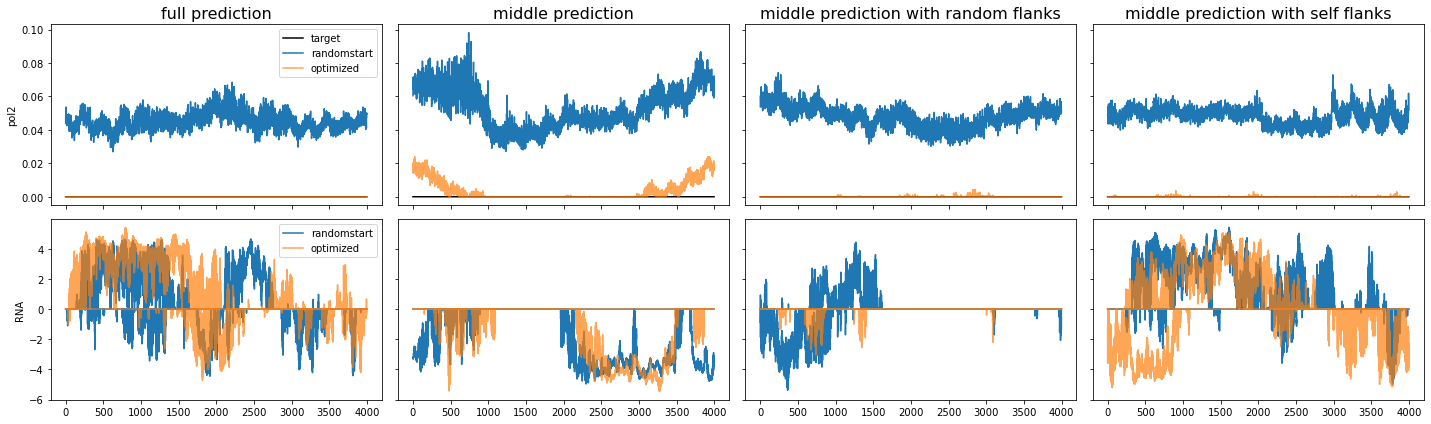

In [162]:
seq_idxes = np.array([0, 2, 12, 22])
titles = ['full prediction', 'middle prediction', 'middle prediction with random flanks', 'middle prediction with self flanks']
length = to_predict.shape[-1]
targ_row = 0
# Merge forward and reverse
merge_pol = utils.mean_on_index((indices_pol, preds_pol), (indices_pol_rev, preds_pol_rev), length=length)
merge_nuc = utils.mean_on_index((indices_nuc, preds_nuc), (indices_nuc_rev, preds_nuc_rev), length=length)
fig, axes = plt.subplots(2, len(seq_idxes), figsize=(20, 6), facecolor='w', layout='tight', sharex=True, sharey='row')
# targ_ax.plot(-target_rev, color='k')
for ax_col, (seq_idx, title) in enumerate(zip(seq_idxes, titles)):
    axes[0, ax_col].set_title(title, fontsize=16)
    axes[targ_row, ax_col].plot(target, color='k', label='target')
    for i, (color, lab, alpha) in enumerate(zip(colors, ['randomstart', 'optimized'], [1, 0.7])):
        axes[0, ax_col].plot(merge_pol[i, seq_idx, :], color=color, label=lab, alpha=alpha)
        # axes[1, ax_col].plot(merge_nuc[i, seq_idx, :], color=color, label=lab, alpha=alpha)
        axes[1, ax_col].plot(indices_rna, preds_rna[i, seq_idx, :], color=color, label=lab, alpha=alpha)
        axes[1, ax_col].plot(indices_rna_rev, -preds_rna_rev[i, seq_idx, :], color=color, alpha=alpha)
    # axes[3, ax_col].bar(np.where(seqs[0, seq_idx] != seqs[1, seq_idx])[0], height=1, width=1.3, color='k', label='mutations')
for ax, ylab in zip(axes[:, 0], ['pol2', 'nucleosome', 'RNA', 'mutations'][::2]):
    ax.legend()
    ax.set_ylabel(ylab)

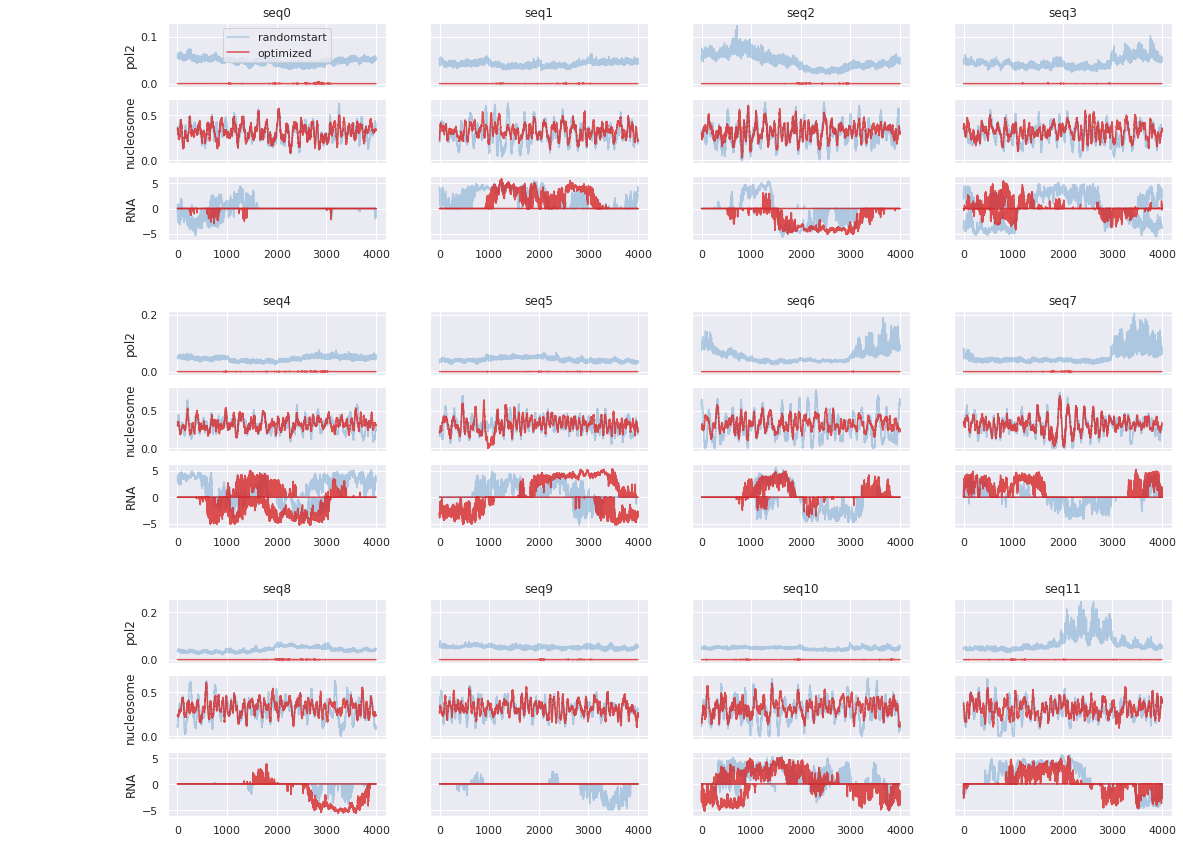

In [209]:
seq_idxes = np.arange(12, 24)
length = to_predict.shape[-1]
# Merge forward and reverse
merge_pol = utils.mean_on_index((indices_pol, preds_pol), (indices_pol_rev, preds_pol_rev), length=length)
merge_nuc = utils.mean_on_index((indices_nuc, preds_nuc), (indices_nuc_rev, preds_nuc_rev), length=length)
fig = plt.figure(figsize=(18, 12), facecolor='w')
subfigs = fig.subfigures(3, 1)
axes = [subfig.subplots(3, 4, sharex=True, sharey='row') for subfig in subfigs]
axes = np.array(axes)
# targ_ax.plot(-target_rev, color='k')
for j, (seq_idx, title) in enumerate(zip(seq_idxes, titles)):
    subfig_row, ax_col = divmod(j, 4)
    axes[subfig_row, 0, ax_col].set_title(f'seq{j}')
    for i, (color, lab, alpha) in enumerate(zip(colors[::3], ['randomstart', 'optimized'], [0.3, 0.8])):
        axes[subfig_row, 0, ax_col].plot(merge_pol[i, seq_idx, :], color=color, label=lab, alpha=alpha)
        axes[subfig_row, 1, ax_col].plot(merge_nuc[i, seq_idx, :], color=color, label=lab, alpha=alpha)
        axes[subfig_row, 2, ax_col].plot(indices_rna, preds_rna[i, seq_idx, :], color=color, label=lab, alpha=alpha)
        axes[subfig_row, 2, ax_col].plot(indices_rna_rev, -preds_rna_rev[i, seq_idx, :], color=color, alpha=alpha)
    # axes[3, ax_col].bar(np.where(seqs[0, seq_idx] != seqs[1, seq_idx])[0], height=1, width=1.3, color='k', label='mutations')
for ax, ylab in zip(axes[:, :, 0].flatten(), ['pol2', 'nucleosome', 'RNA']*3):
    ax.set_ylabel(ylab)
axes[0, 0, 0].legend()

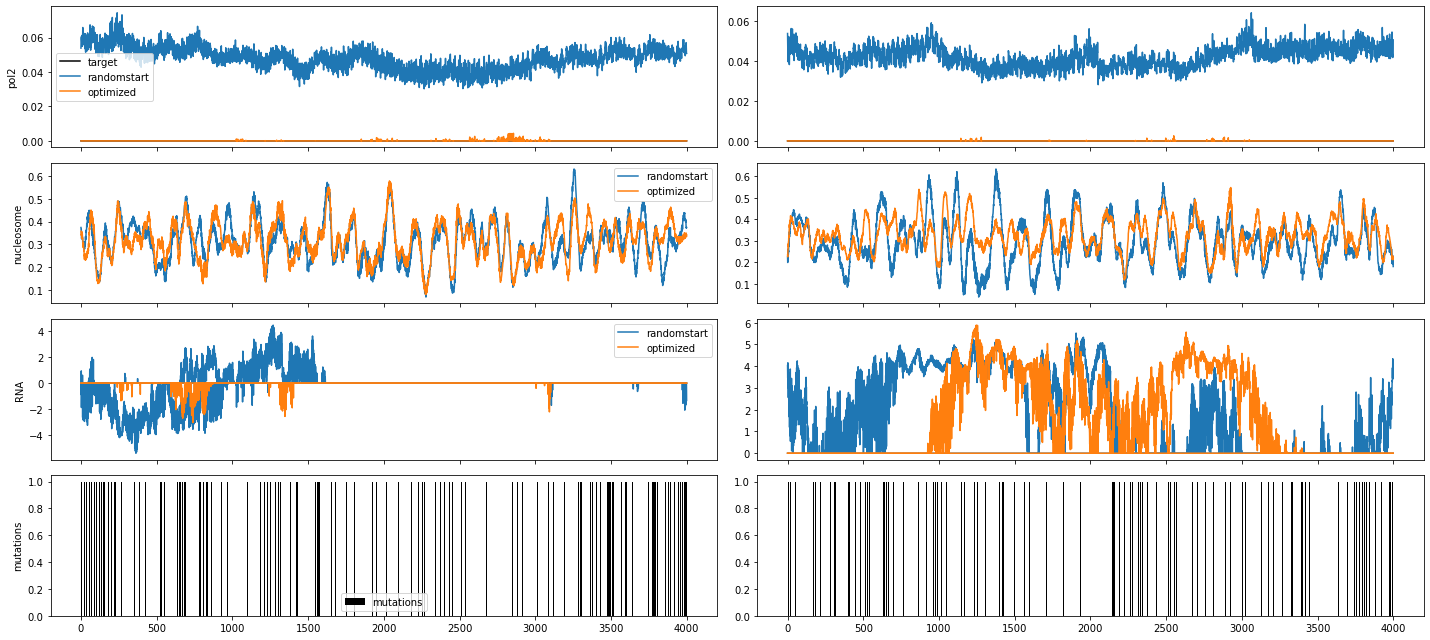

In [132]:
start = 0
stop = 2
n_seqs = stop - start
length = to_predict.shape[-1]
targ_row = 0
# Merge forward and reverse
merge_pol = utils.mean_on_index((indices_pol, preds_pol), (indices_pol_rev, preds_pol_rev), length=length)
merge_nuc = utils.mean_on_index((indices_nuc, preds_nuc), (indices_nuc_rev, preds_nuc_rev), length=length)
fig, axes = plt.subplots(4, n_seqs, figsize=(20, 9), facecolor='w', layout='tight', sharex=True)
# targ_ax.plot(-target_rev, color='k')
for seq_idx in range(start, stop):
    ax_col = seq_idx - start
    axes[targ_row, ax_col].plot(target, color='k', label='target')
    for i, (step, color) in enumerate(zip(steps, colors)):
        axes[0, ax_col].plot(merge_pol[seq_idx, i, :], color=color, label=f'step{step}')
        axes[1, ax_col].plot(merge_nuc[seq_idx, i, :], color=color, label=f'step{step}')
        axes[2, ax_col].plot(indices_rna, preds_rna[seq_idx, i, :], color=color, label=f'step{step}')
        axes[2, ax_col].plot(indices_rna_rev, -preds_rna_rev[seq_idx, i, :], color=color)
    axes[3, ax_col].bar(np.where(seqs[seq_idx, steps[0]] != seqs[seq_idx, steps[-1]])[0], height=1, width=1.3, color='k', label='mutations')
for ax, ylab in zip(axes[:, 0], ['pol2', 'nucleosome', 'RNA', 'mutations']):
    ax.legend()
    ax.set_ylabel(ylab)
# filename = utils.safe_filename(f'/home/alex/shared_folder/SCerevisiae/results/generated/{exp_name}/all_profiles_start_end.png')
# fig.savefig(filename, bbox_inches='tight')

In [ ]:
seq_idx = 0
fig, axes = plt.subplots(4, 1, figsize=(20, 9), facecolor='w', layout='tight', sharex=True)
for i in range(0, 6, 5):
    step = i*100
    color = colors[i]
    axes[0].plot(indices_pol, preds_pol[seq_idx, i, :], color=color, label=f'step{step}')
    axes[0].plot(indices_pol_rev, -preds_pol_rev[seq_idx, i, :], color=color)
    axes[1].plot(indices_nuc, preds_nuc[seq_idx, i, :], color=color, label=f'step{step}')
    axes[1].plot(indices_nuc_rev, -preds_nuc_rev[seq_idx, i, :], color=color)
    axes[2].plot(indices_rna, preds_rna[seq_idx, i, :], color=color, label=f'step{step}')
    axes[2].plot(indices_rna_rev, -preds_rna_rev[seq_idx, i, :], color=color)
# targ_ax = axes[1]
# targ_ax.plot(target, color='k', label='target')
# targ_ax.plot(-target_rev, color='k')
axes[3].bar(np.where(seqs[seq_idx, 0] != seqs[seq_idx, step])[0], height=1, color='k', label='mutations')
for ax, ylab in zip(axes, ['pol2', 'nucleosome', 'RNA', 'mutations']):
    ax.legend()
    ax.set_ylabel(ylab)

Testing predict functions

In [10]:
n = 10
l = 4000
freq_kmers = pd.read_csv('/home/alex/shared_folder/SCerevisiae/genome/W303/W303_3mer_freq.csv', index_col=[0, 1, 2])
np.random.seed(0)
seqs = utils.random_sequences(n, l, freq_kmers.iloc[:, 0], out='idx')
print(seqs.shape)
print(seqs)

(10, 4000)
[[2 0 3 ... 0 1 0]
 [3 0 1 ... 1 3 0]
 [2 2 0 ... 3 3 2]
 ...
 [3 2 3 ... 0 3 3]
 [3 3 3 ... 1 1 2]
 [1 1 0 ... 2 3 3]]


In [ ]:
to_predict = seqs#[:, ::100]
print(to_predict.shape)
preds = get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=None)
preds_rev = get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=None, reverse=True)
preds_flanks = []
preds_flanks_rev = []
for i in range(len(flank_left)):
    flanks=(flank_left[i], flank_right[i])
    preds_flanks.append(get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=flanks))
    preds_flanks_rev.append(get_profile_hint(to_predict, model_pol, 2048, 128, middle=True, flanks=flanks, reverse=True))
preds_flanks = np.array(preds_flanks)
preds_flanks_rev = np.array(preds_flanks_rev)
print(preds.shape, preds_rev.shape)
print(preds_flanks.shape, preds_flanks_rev.shape)

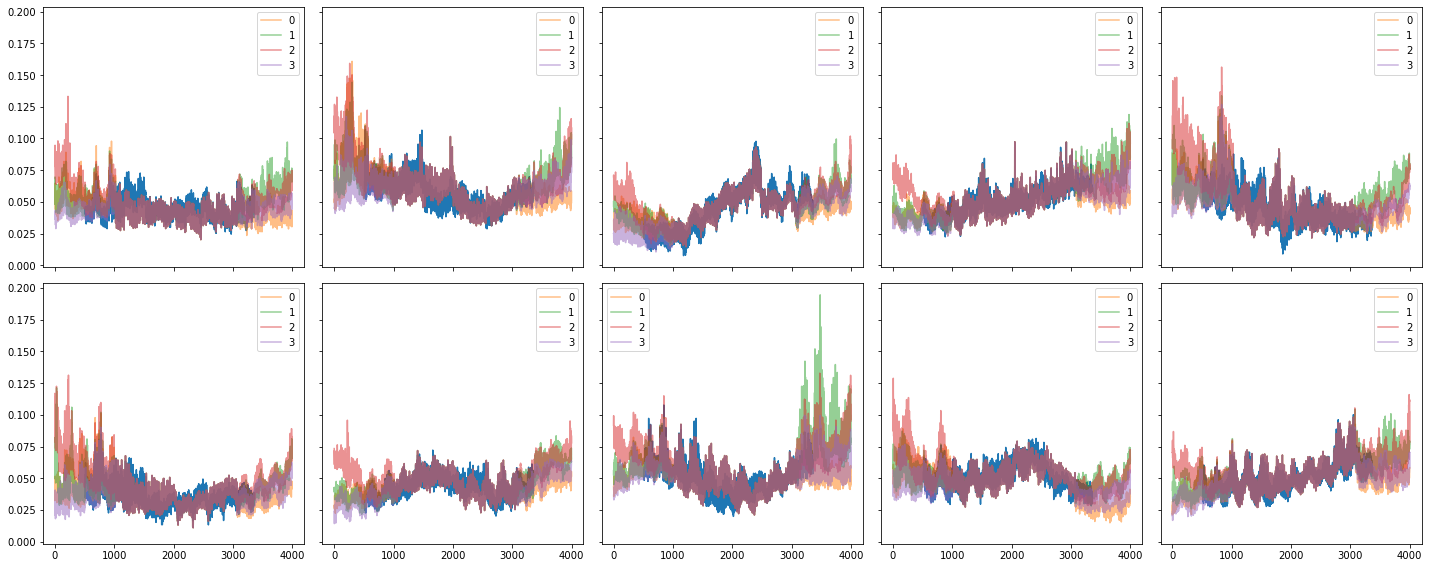

In [41]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8), facecolor='w', layout='tight', sharex=True, sharey=True)
start = 0
stop = 4
for i, ax in enumerate(axes.flatten()):
    ax.plot(np.arange(512, 512+preds.shape[-1]), preds[i])
    # ax.plot(np.arange(512+127, 512+127+preds.shape[-1]), preds_rev[i])
    ax.plot(preds_flanks[start:stop, i].T, label=[i for i in range(start, stop)], alpha=0.5)
    # ax.plot(preds_flanks_rev[start:stop, i].T, alpha=0.5)
    ax.legend()

# Saliency

In [4]:
def get_gradients(model, one_hots, batch_size=1024, predict=False, head_start=0, n_heads=1):
    grads = np.empty(one_hots.shape, dtype='float32')
    n_batches = int(np.ceil((len(one_hots) / batch_size)))
    preds = None
    for i in range(n_batches):
        batch_start, batch_stop = i*batch_size, (i+1)*batch_size
        X = tf.Variable(one_hots[batch_start:batch_stop], dtype=tf.float32)
        with tf.GradientTape() as tape:
            Y = model(X, training=False)[:, head_start:head_start+n_heads]
        grads[batch_start:batch_stop] = np.array(tape.gradient(Y, X))
        if predict:
            Y = np.array(Y).squeeze()
            if i == 0:
                preds = np.empty((len(one_hots),) + Y.shape[1:],
                                 dtype='float32')
            preds[batch_start:batch_stop] = Y
    if predict:
        return grads.squeeze(), preds
    else:
        return grads.squeeze()

In [7]:
with np.load('/home/alex/shared_folder/SCerevisiae/results/model_myco_pol_17/preds_mid_on_W303_Mmmyco.npz') as f:
    preds_pol = {k: f[k] for k in f.keys() if k[:3] == 'chr'}

In [2]:
with np.load('/home/alex/shared_folder/SCerevisiae/data/GSE217022/labels_myco_pol_ratio.npz') as f:
    labels_pol = {k: f[k] for k in f.keys() if k[:3] == 'chr'}

In [3]:
with np.load('/home/alex/shared_folder/SCerevisiae/data/labels_myco_nuc.npz') as f:
    labels_nuc = {k: f[k] for k in f.keys() if k[:3] == 'chr'}

In [73]:
scales = 4**np.arange(9)
corrs = pd.DataFrame(index=scales, columns=list(labels_pol.keys()))
corrs_bin = pd.DataFrame(index=scales, columns=list(labels_pol.keys()))
corrs_bin_concat = pd.Series(index=scales, dtype='float')
for scale in scales:
    sigs1 = []
    sigs2 = []
    for chr_id in labels_pol.keys():
        sig1 = utils.smooth(labels_pol[chr_id], scale, padding='valid')
        sig2 = utils.smooth(labels_nuc[chr_id], scale, padding='valid')
        corrs.loc[scale, chr_id] = pearsonr(sig1, sig2)[0]
        sig1 = utils.bin_values(labels_pol[chr_id], scale)
        sig2 = utils.bin_values(labels_nuc[chr_id], scale)
        sigs1.append(sig1)
        sigs2.append(sig2)
        corrs_bin.loc[scale, chr_id] = pearsonr(sig1, sig2)[0]
    sigs1 = np.concatenate(sigs1)
    sigs2 = np.concatenate(sigs2)
    corrs_bin_concat.loc[scale] = pearsonr(sigs1, sigs2)[0]
corrs

chrI     chrII    chrIII     chrIV      chrV     chrVI    chrVII  \
1      0.038744 -0.030824  0.042068  0.006136 -0.002353 -0.007658 -0.021717   
4      0.038797  -0.03089  0.042135  0.006139 -0.002368 -0.007687 -0.021765   
16     0.039406 -0.031653  0.042773  0.006145 -0.002535 -0.008004 -0.022306   
64     0.045993 -0.041722  0.049513  0.005587 -0.005199 -0.012255 -0.029578   
256    0.060048 -0.102053  0.059406 -0.009905 -0.030328 -0.041214 -0.075312   
1024   0.035802   -0.2063  0.035032 -0.052868 -0.090764 -0.101847 -0.155624   
4096   0.055058 -0.158823  0.137318  0.054912   0.01924 -0.045495 -0.135883   
16384  0.236451 -0.072553  0.294304  0.213336  0.292306 -0.078324 -0.046262   
65536  0.626823  0.038571 -0.279934  0.357624  0.487447 -0.217223  0.259067   

        chrVIII     chrIX      chrX     chrXI    chrXII   chrXIII    chrXIV  \
1      0.003741 -0.007717 -0.001916 -0.019657  0.028459 -0.010434 -0.011248   
4      0.003737 -0.007744  -0.00193 -0.019705  0.028496 -0.010462  -0.01128   
16     0.003691 -0.008021 -0.002093  -0.02024  0.028897 -0.010779  -0.01165   
64     0.002591 -0.011818 -0.004594 -0.027612   0.03308 -0.015224 -0.016979   
256   -0.013653 -0.041605 -0.025216 -0.079048  0.037539 -0.047689 -0.056627   
1024   -0.05006  -0.10172  -0.06152  -0.18816  0.024447  -0.11767 -0.126716   
4096   0.063495 -0.091026  0.041726 -0.214257  0.149248 -0.046198 -0.096015   
16384  0.221904 -0.313857  0.153694 -0.148696  0.394832  0.109382  -0.08408   
65536  0.392919 -0.361378  0.027671  0.033753  0.363022  0.061133 -0.063672   

          chrXV    chrXVI  
1     -0.037028 -0.017746  
4     -0.037106 -0.017785  
16    -0.037976  -0.01825  
64    -0.049253 -0.024699  
256   -0.115127 -0.069051  
1024  -0.211575  -0.15059  
4096  -0.183812 -0.063825  
16384 -0.088763  0.059552  
65536 -0.221401 -0.118757

Text(0, 0.5, 'full genome binning')

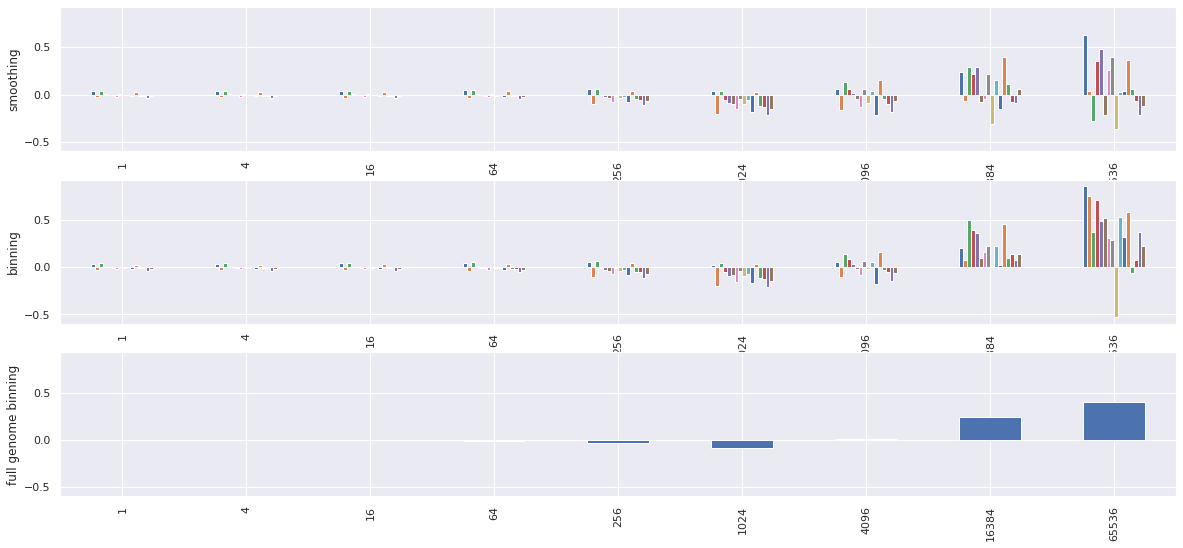

In [74]:
fig, axes = plt.subplots(3, 1, figsize=(20, 9), sharey=True)
corrs.plot(kind='bar', legend=False, ax=axes[0])
axes[0].set_ylabel('smoothing')
corrs_bin.plot(kind='bar', legend=False, ax=axes[1])
axes[1].set_ylabel('binning')
corrs_bin_concat.plot(kind='bar', legend=False, ax=axes[2])
axes[2].set_ylabel('full genome binning')

In [81]:
scale = 4**7
offsets = np.arange(0, scale, scale//16)
print(offsets)
corrs_bin2 = pd.DataFrame(index=offsets, columns=list(labels_pol.keys()))
corrs_bin_concat2 = pd.Series(index=offsets, dtype='float')
for offset in offsets:
    sigs1 = []
    sigs2 = []
    for chr_id in labels_pol.keys():
        sig1 = utils.bin_values(labels_pol[chr_id][offset:], scale)
        sig2 = utils.bin_values(labels_nuc[chr_id][offset:], scale)
        sigs1.append(sig1)
        sigs2.append(sig2)
        corrs_bin2.loc[offset, chr_id] = pearsonr(sig1, sig2)[0]
    sigs1 = np.concatenate(sigs1)
    sigs2 = np.concatenate(sigs2)
    corrs_bin_concat2.loc[offset] = pearsonr(sigs1, sigs2)[0]
corrs_bin2

[    0  1024  2048  3072  4096  5120  6144  7168  8192  9216 10240 11264
 12288 13312 14336 15360]


chrI     chrII    chrIII     chrIV      chrV     chrVI    chrVII  \
0      0.208061  0.074981  0.497691  0.391062  0.360465  0.096529  0.162375   
1024   0.230056  0.100755  0.566989  0.396693  0.356843  0.051184    0.1389   
2048   0.236304  0.113688  0.567623  0.367151  0.383277  0.059614  0.110582   
3072    0.25695  0.142594  0.568495  0.319052  0.392701  0.034032  0.105232   
4096   0.272025  0.157187  0.492794  0.306718  0.365143 -0.037522  0.072441   
5120   0.303032  0.120978  0.503844  0.312011  0.361205 -0.057859  0.076233   
6144    0.34054  0.110223  0.476854  0.301442  0.364342 -0.026078  0.109457   
7168   0.385758  0.110286  0.382547  0.299124  0.380762 -0.039983  0.129769   
8192   0.372653  0.088546  0.297945  0.301444  0.387409  0.058762  0.145649   
9216   0.379764   0.11359  0.241259  0.206138  0.373911 -0.159324 -0.011344   
10240  0.429926  0.118827  0.188793  0.198318  0.361124  -0.18668  0.006852   
11264  0.433104  0.109425  0.164757  0.231834  0.385714 -0.198373  0.049441   
12288   0.39296  0.207372  0.268383  0.227563  0.430792 -0.173905  0.154286   
13312  0.361422  0.211219  0.477141  0.253777  0.442035 -0.209942  0.169232   
14336  0.397275  0.191704  0.540549  0.280199  0.453721 -0.278039  0.175217   
15360  0.400778  0.201397  0.508294  0.317057  0.450531 -0.304471  0.158473   

        chrVIII     chrIX      chrX     chrXI    chrXII   chrXIII    chrXIV  \
0      0.227824  0.013765  0.222008   0.01951  0.452653   0.09594   0.13626   
1024    0.22551 -0.136911  0.214029  0.050764  0.460168  0.097843  0.135254   
2048   0.276284 -0.151911  0.213266  0.037175  0.466039  0.090821  0.092532   
3072   0.300377 -0.264135  0.214775 -0.001017  0.471834  0.093035  0.079097   
4096   0.322948 -0.397233  0.205858 -0.007097   0.46976  0.102857  0.103351   
5120   0.355522 -0.476563  0.173364 -0.012535  0.475714  0.089279  0.107569   
6144   0.339444 -0.468863  0.167571  0.090327  0.444959  0.111495  0.145602   
7168   0.323041 -0.423034  0.113661 -0.012585  0.452952  0.102512  0.151558   
8192     0.1995 -0.431075  0.086643 -0.031718  0.450377  0.105137  0.071451   
9216   0.195608 -0.390807  0.090733 -0.053908  0.431905  0.172598  0.036912   
10240  0.199444 -0.369341  0.069462 -0.020579  0.400155  0.228793  0.000085   
11264    0.2033  -0.35311  0.094162 -0.008574  0.400732  0.221537 -0.007067   
12288  0.174866 -0.293724  0.152402  0.011016  0.395988  0.264074  0.005813   
13312  0.166126 -0.235786  0.165664 -0.029242  0.400529    0.2613   0.00767   
14336  0.188695 -0.322789  0.126251 -0.031495   0.40649  0.232755  0.029471   
15360  0.175472 -0.234671   0.11133  0.004786  0.414961  0.121554  0.020236   

          chrXV    chrXVI  
0       0.07309    0.1375  
1024   0.103215   0.12874  
2048   0.135925    0.1217  
3072   0.141389  0.105916  
4096   0.156607  0.086483  
5120   0.182641  0.071514  
6144   0.205631   0.07171  
7168   0.199111  0.097737  
8192   0.208409  0.080892  
9216   0.218805  0.084189  
10240  0.088466  0.020582  
11264  0.065693 -0.067184  
12288  0.063502 -0.034656  
13312  0.048807 -0.030259  
14336  0.040017 -0.057103  
15360  0.052456 -0.033668

Text(0, 0.5, 'full genome binning')

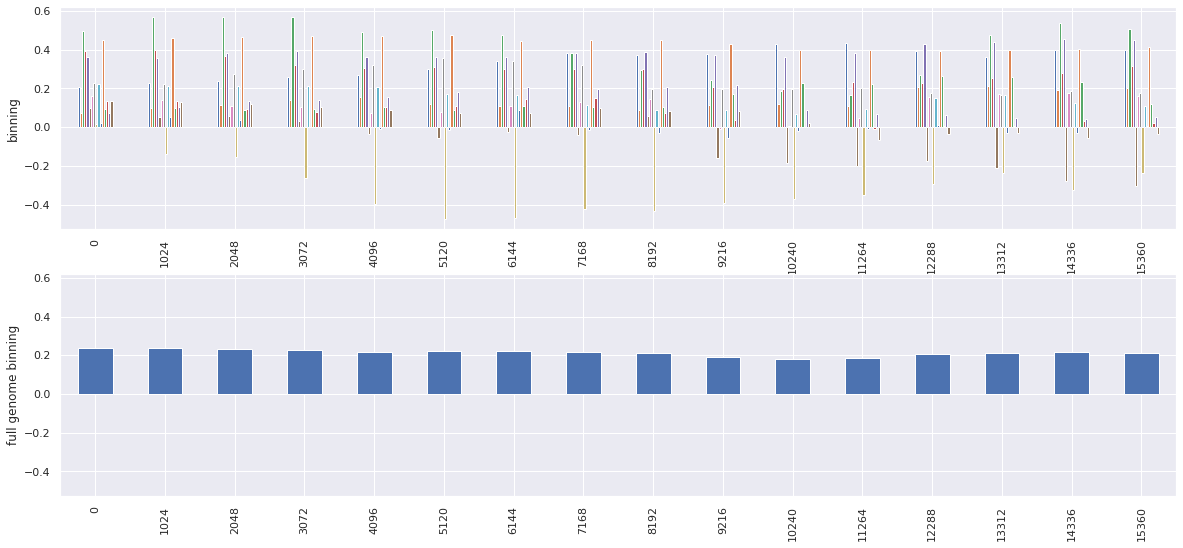

In [82]:
fig, axes = plt.subplots(2, 1, figsize=(20, 9), sharey=True)
corrs_bin2.plot(kind='bar', legend=False, ax=axes[0])
axes[0].set_ylabel('binning')
corrs_bin_concat2.plot(kind='bar', legend=False, ax=axes[1])
axes[1].set_ylabel('full genome binning')

In [6]:
lags = np.arange(0, 5000, 10)
lag_cors = {}
for chr_id, signal in labels_pol.items():
    lag_cors[chr_id] = utils.fast_sliding_correlation(signal, signal, lags)

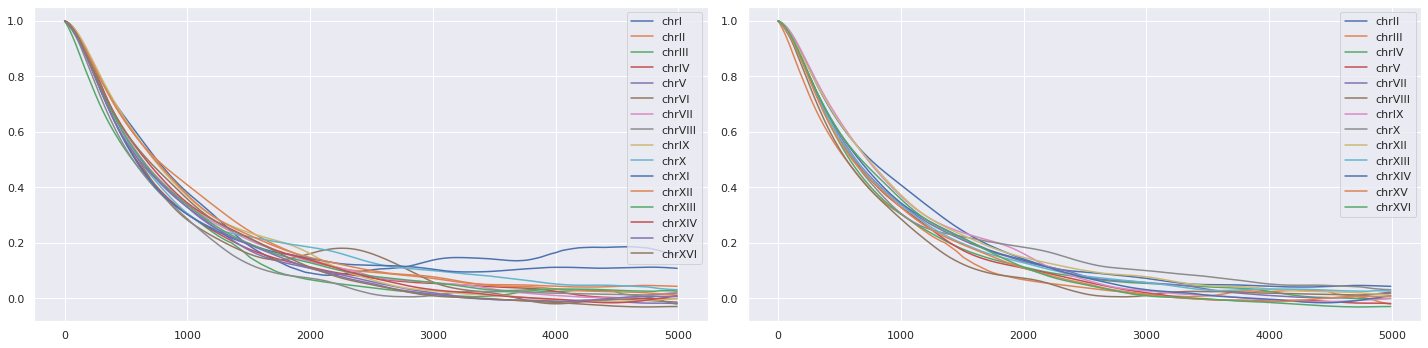

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), facecolor='w', layout='tight')
for chr_id, corr in lag_cors.items():
    axes[0].plot(lags, corr, label=chr_id)
    if chr_id not in ['chrI', 'chrVI', 'chrXI']:
        axes[1].plot(lags, corr, label=chr_id)
for ax in axes:
    ax.legend()

In [59]:
lags = np.arange(0, 1000, 2)
lag_cors = {}
for chr_id, signal in labels_nuc.items():
    lag_cors[chr_id] = utils.fast_sliding_correlation(signal, signal, lags)

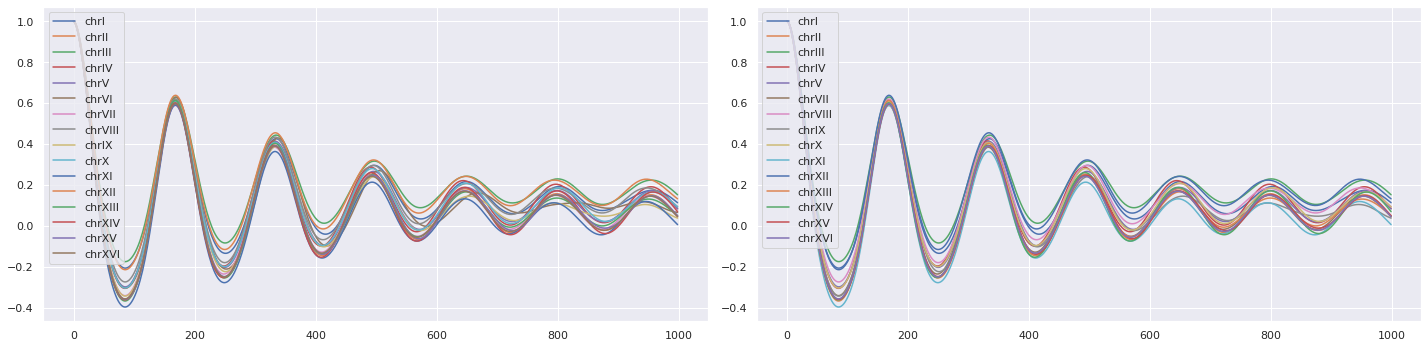

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), facecolor='w', layout='tight')
for chr_id, corr in lag_cors.items():
    axes[0].plot(lags, corr, label=chr_id)
    if chr_id not in ['chrVI']:
        axes[1].plot(lags, corr, label=chr_id)
for ax in axes:
    ax.legend()

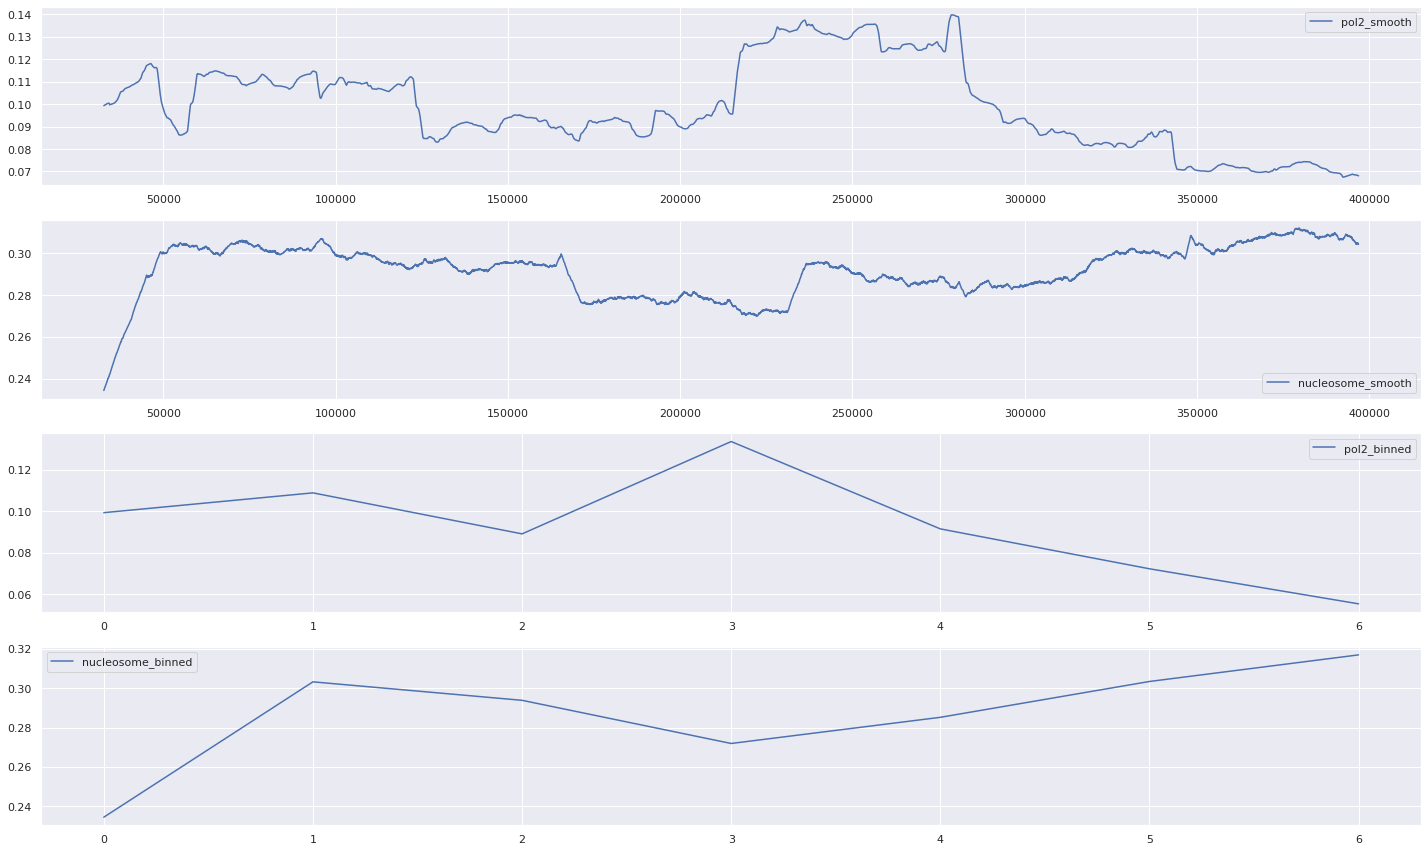

In [95]:
chr_id = 'chrIX' # 'chrIV'
start = 0 # 38912
stop = 2_000_000 # 40960
scale = 4**8
offset = 0
resolution = 1 # scale // 10
stop = min(stop, len(labels_pol[chr_id]))
midlen = 128*8
fig, axes = plt.subplots(4, 1, figsize=(20, 12), facecolor='w', layout='tight')
axes[0].plot(np.arange(start + scale//2, stop - scale//2, resolution), utils.smooth(labels_pol[chr_id], scale, padding='valid')[start:stop-scale+scale%2:resolution], label='pol2_smooth')
axes[1].plot(np.arange(start + scale//2, stop - scale//2, resolution), utils.smooth(labels_nuc[chr_id], scale, padding='valid')[start:stop-scale+scale%2:resolution], label='nucleosome_smooth')
axes[2].plot(utils.bin_values(labels_pol[chr_id][offset:], scale), label='pol2_binned')
axes[3].plot(utils.bin_values(labels_nuc[chr_id][offset:], scale), label='nucleosome_binned')
# ax.plot(np.arange(start, stop), preds_pol[chr_id][start:stop], label='ref_preds')
# sep = start + midlen - (start - midlen//2) % midlen
# while sep < stop:
#     ax.axvline(sep, color='k', linestyle='--')
#     sep += midlen
for ax in axes:
    ax.legend()

In [47]:
winsize = 2048
head_interval = 128
offset = 0
one_hots = utils.strided_sliding_window_view(
    one_hot_yeast[chr_id][start+offset:stop+offset+head_interval-1],
    (winsize, 4),
    winsize//2,
    head_interval).reshape(-1, winsize, 4)
one_hots.shape

(128, 2048, 4)

In [57]:
winsize = 2048
head_start = 8
offset = -128*8
one_hots = utils.sliding_window_view(
    one_hot_yeast[chr_id][start+offset:stop+offset+winsize-1],
    (winsize, 4)).reshape(-1, winsize, 4)
one_hots.shape

(2048, 2048, 4)

In [58]:
grads, preds = get_gradients(model_pol, one_hots, predict=True, head_start=8, n_heads=1)
preds_t = preds.T.ravel()
print(preds.shape)

(2048,)


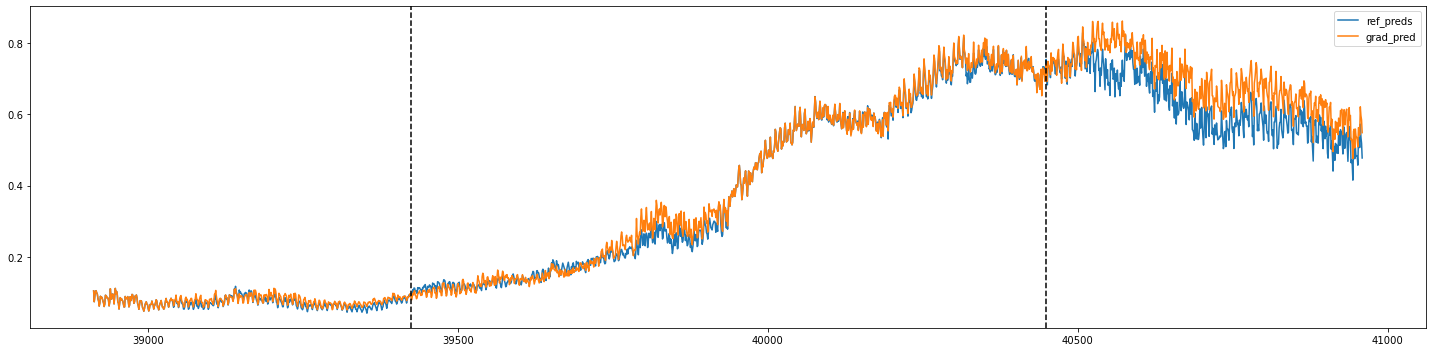

In [60]:
chr_id = 'chrIV'
start = 38912
stop = 40960
midlen = 128*8
fig, ax = plt.subplots(1, 1, figsize=(20, 5), facecolor='w', layout='tight')
ax.plot(np.arange(start, stop), preds_pol[chr_id][start:stop], label='ref_preds')
# ax.plot(np.arange(start + midlen//2, stop - midlen//2), preds_t, label='grad_pred')
ax.plot(np.arange(start, stop), preds_t, label='grad_pred')
sep = start + midlen - (start - midlen//2) % midlen
while sep < stop:
    ax.axvline(sep, color='k', linestyle='--')
    sep += midlen
ax.legend()

In [61]:
print(grads.shape)
grads_proj = grads - grads.mean(axis=-1, keepdims=True)
print(grads_proj.shape)
grads_seq = grads[one_hots].reshape(grads.shape[:-1])
print(grads_seq.shape)
grads_proj_seq = grads_proj[one_hots].reshape(grads.shape[:-1])
print(grads_proj_seq.shape)

(2048, 2048, 4)
(2048, 2048, 4)
(2048, 2048)
(2048, 2048)


<AxesSubplot:>

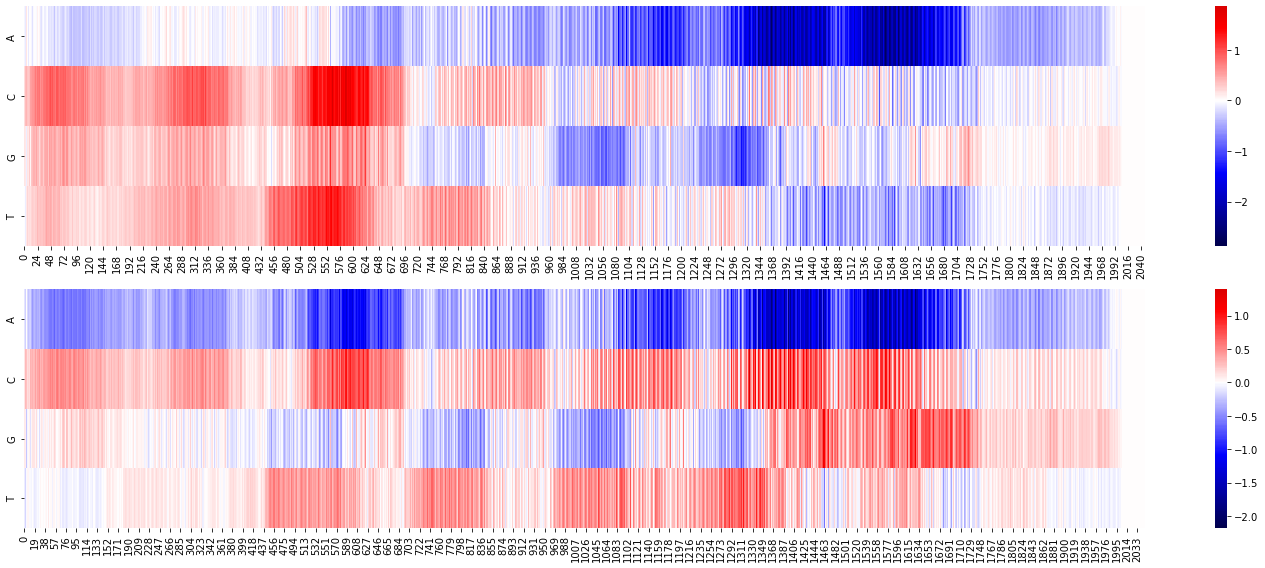

In [62]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight')
# sns.heatmap(grads_proj[0].T, ax=ax, cmap='seismic', center=0)
vmin = None # -2
sns.heatmap(grads.sum(axis=0).T, cmap='seismic', center=0, vmin=vmin, ax=axes[0],# cbar_ax=axes[0, 1],
            yticklabels=list('ACGT'))
sns.heatmap(grads_proj.sum(axis=0).T, cmap='seismic', center=0, vmin=vmin, ax=axes[1],# cbar_ax=axes[0, 1],
            yticklabels=list('ACGT'))

In [64]:
n_seqs = 2048
winsize = 2048
aligned_grads_seq = np.zeros((n_seqs, winsize+n_seqs), dtype='float32')
for j in range(n_seqs):
    aligned_grads_seq[j, j:j+winsize] = grads_seq[j]
print(aligned_grads_seq.shape)
aligned_grads_proj_seq = np.zeros((n_seqs, winsize+n_seqs), dtype='float32')
for j in range(n_seqs):
    aligned_grads_proj_seq[j, j:j+winsize] = grads_proj_seq[j]
print(aligned_grads_proj_seq.shape)

(2048, 4096)
(2048, 4096)


<AxesSubplot:>

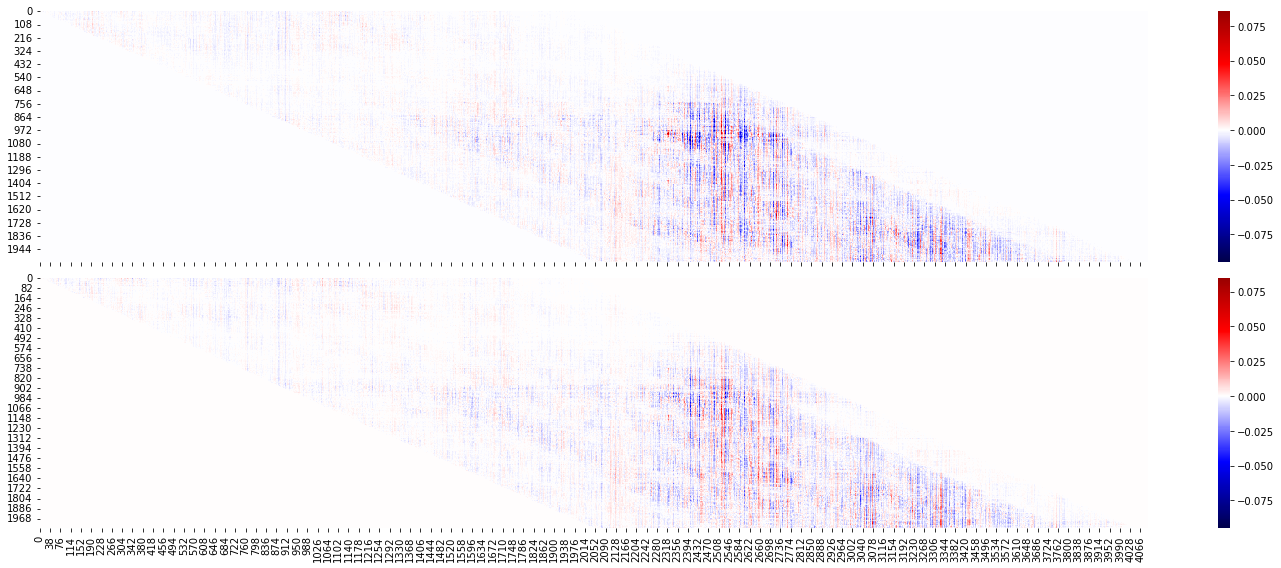

In [65]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight', sharex=True)
vmin = None # -2
sns.heatmap(aligned_grads_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[0])
sns.heatmap(aligned_grads_proj_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[1])

<AxesSubplot:>

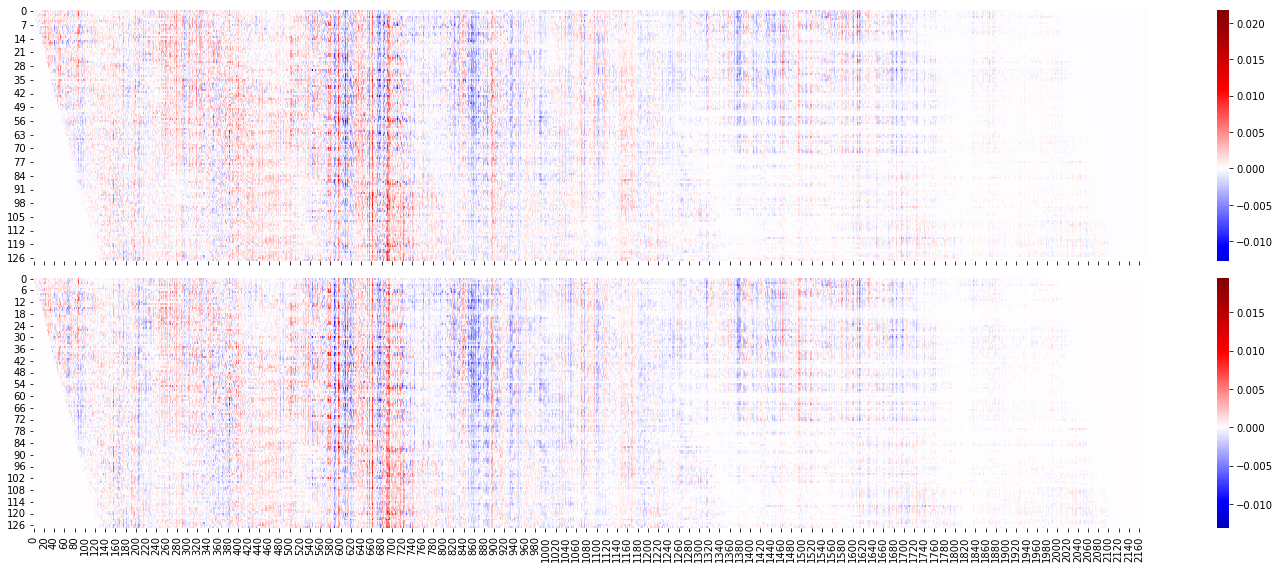

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight', sharex=True)
vmin = None # -2
sns.heatmap(aligned_grads_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[0])
sns.heatmap(aligned_grads_proj_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[1])

<AxesSubplot:>

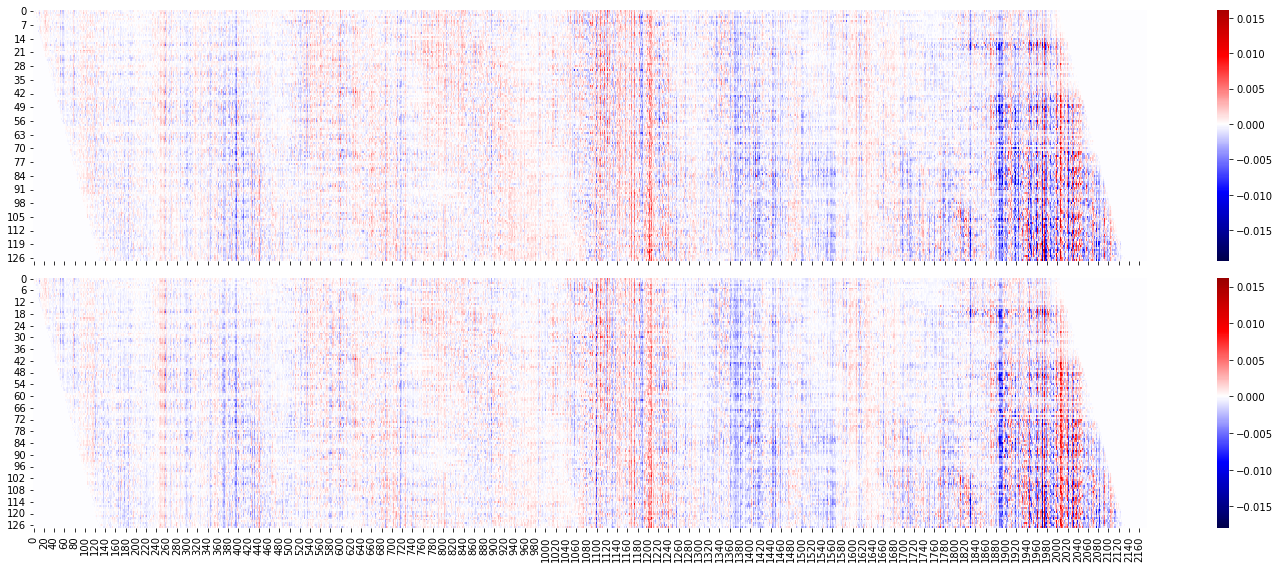

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8), facecolor='w', layout='tight', sharex=True)
vmin = None # -2
sns.heatmap(aligned_grads_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[0])
sns.heatmap(aligned_grads_proj_seq, cmap='seismic', center=0, vmin=vmin, ax=axes[1])

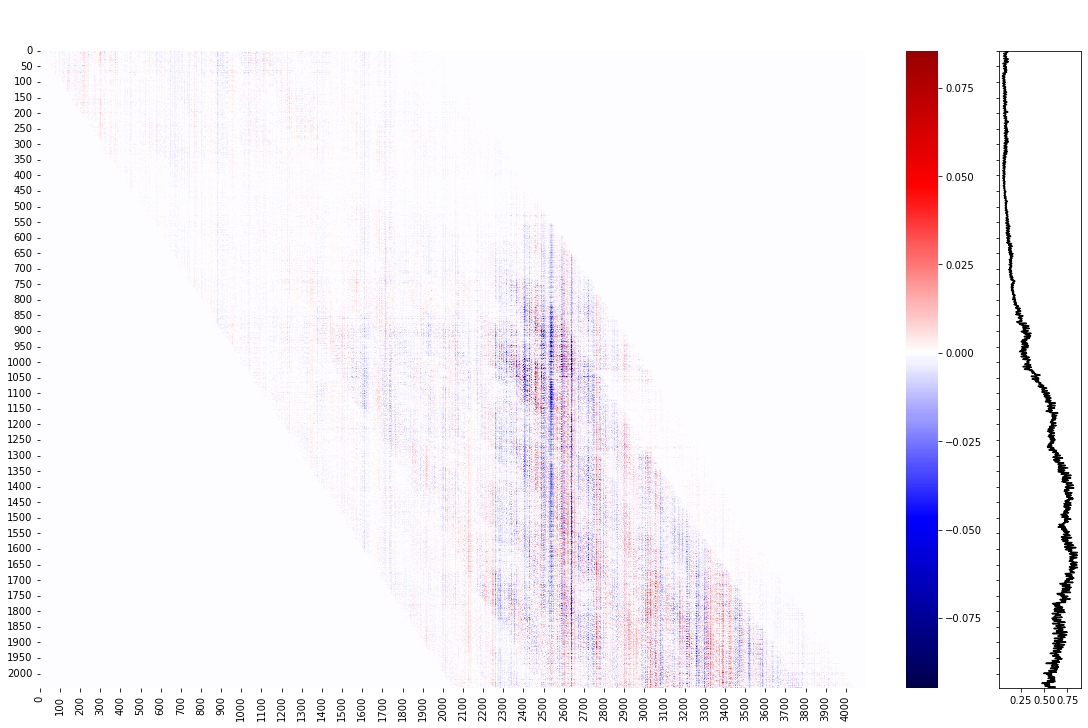

In [69]:
plot_start = 0
plot_stop = 4096
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey='row', sharex='col', layout='constrained',
                         gridspec_kw={'width_ratios': [10, 1],
                                      'height_ratios': [1, 20]})
fig.set_facecolor('w')
# lm.Logo(pd.DataFrame(one_hot_yeast['chrIV'][start+plot_start:start+plot_stop], columns=list('ACGT')), ax=axes[0, 0])
axes[0, 0].set_axis_off()
axes[0, 1].remove()
sns.heatmap(aligned_grads_seq[:, plot_start:plot_stop], cmap='seismic', center=0, ax=axes[1, 0],
            xticklabels=100, yticklabels=50)
axes[1, 1].plot(preds, np.arange(len(preds)), color='k', label='predictions')
plt.show()
plt.close()